In [1]:
%matplotlib inline

import datetime
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

# How to enable Colab GPUs https://colab.research.google.com/notebooks/gpu.ipynb
# Select the Runtime > "Change runtime type" menu to enable a GPU accelerator,
# and then re-execute this cell.
if 'google.colab' in str(get_ipython()):
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, \
                         BatchNormalization, GlobalAveragePooling1D, Flatten, \
                         Reshape, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Found GPU at: /device:GPU:0
env: PYTHONHASHSEED=0


# LSTM Networks for Cambridge UK Weather Time Series

Building LSTM models for time series analysis of Cambridge UK temperature measurements taken at the [University computer lab weather station](https://www.cl.cam.ac.uk/research/dtg/weather/).


I'm primarily interested in short term temperature forecasts (less than 2 hours) but will include results up to 24 hours in the future.

See my previous work for further details:
 * [Cambridge UK temperature forecast python notebooks](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks)
 * [Cambridge UK temperature forecast R models](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
 * [Bayesian optimisation of prophet temperature model](https://github.com/makeyourownmaker/BayesianProphet)
 * [Cambridge University Computer Laboratory weather station R shiny web app](https://github.com/makeyourownmaker/ComLabWeatherShiny)


## Import Data

The measurements are relatively noisy and there are usually several hundred missing values every year.
Observations have been extensively cleaned but may still have issues.  Interpolation and missing value imputation have been used to fill all missing values.  See the [cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning) in the [Cambridge Temperature Model repository](https://github.com/makeyourownmaker/CambridgeTemperatureModel) for details.  Observations start in August 2008 and end in April 2021 and occur every 30 mins.

Shape:
(223250, 7)

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 223250 entries, 2008-08-01 00:30:00 to 2021-04-26 01:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ds                 223250 non-null  datetime64[ns]
 1   y                  223250 non-null  float64       
 2   humidity           223250 non-null  float64       
 3   dew.point          223250 non-null  float64       
 4   pressure           223250 non-null  float64       
 5   wind.speed.mean    223250 non-null  float64       
 6   wind.bearing.mean  223250 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 13.6 MB
None

Summary stats:


,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean
count,223250.000000,223250.000000,223250.000000,223250.000000,223250.000000,223250.000000
mean,10.000512,78.689959,58.880634,1014.336135,4.432390,195.051399
std,6.496255,17.274417,51.630120,11.935364,4.013553,82.881764
min,-7.000000,20.000000,-100.000000,963.000000,0.000000,0.000000
25%,5.200000,68.000000,20.000000,1008.000000,1.200000,135.000000
50%,9.600000,83.000000,60.000000,1016.000000,3.500000,225.000000
75%,14.500000,92.000000,97.000000,1022.000000,6.600000,270.000000
max,36.100000,100.000000,209.000000,1051.000000,29.200000,360.000000



Raw data:


,ds,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean
ds,,,,,,,
2008-08-01 00:30:00,2008-08-01 00:30:00,19.5,65.75000,119.150000,1014.416667,1.150000,225.0
2008-08-01 01:00:00,2008-08-01 01:00:00,19.1,49.75000,79.200000,1014.384615,1.461538,225.0
2008-08-01 01:30:00,2008-08-01 01:30:00,19.1,66.17875,106.600000,1014.500000,1.508333,225.0
2008-08-01 02:00:00,2008-08-01 02:00:00,19.1,58.50000,99.250000,1014.076923,1.430769,225.0
2008-08-01 02:30:00,2008-08-01 02:30:00,19.1,66.95000,121.883333,1014.416667,1.133333,225.0
...,...,...,...,...,...,...,...
2021-04-25 23:00:00,2021-04-25 23:00:00,3.6,61.00000,-32.000000,1028.000000,1.400000,45.0
2021-04-25 23:30:00,2021-04-25 23:30:00,3.6,64.00000,-26.000000,1028.000000,2.600000,45.0
2021-04-26 00:00:00,2021-04-26 00:00:00,3.6,58.00000,-39.000000,1028.000000,4.300000,45.0


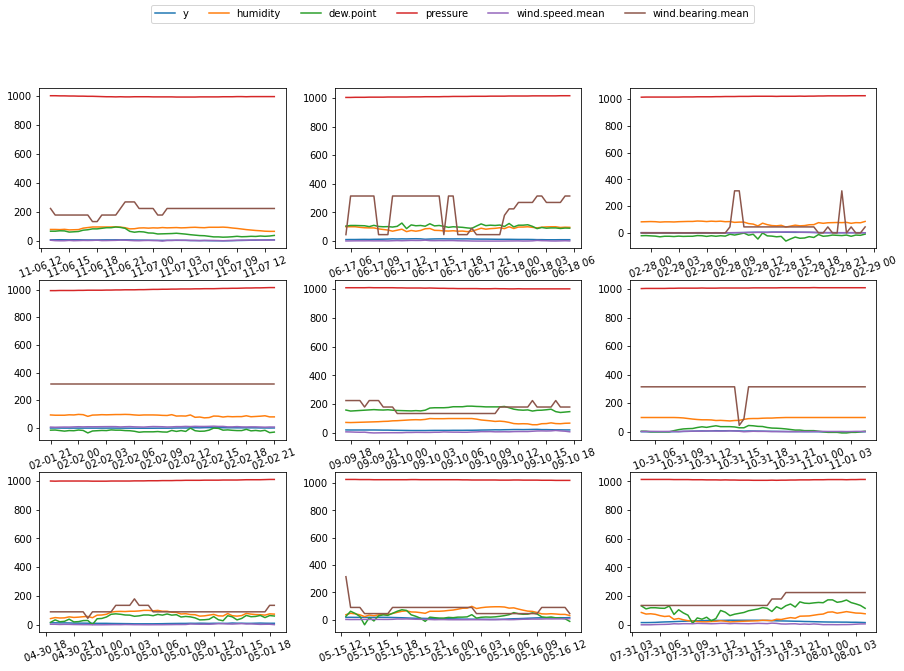

In [53]:
if 'google.colab' in str(get_ipython()):
    data_loc = "https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/CamMetCleanish2021.04.26.csv?raw=true"
else:
    data_loc = "../data/CamMetCleanish2021.04.26.csv"
df = pd.read_csv(data_loc, parse_dates = True)

df['ds'] = pd.to_datetime(df['ds'])
df.set_index(df['ds'], drop = False, inplace = True)
df = df[~df.index.duplicated(keep = 'first')]

df['y'] = df['y'] / 10
df['wind.speed.mean'] = df['wind.speed.mean'] / 10

df = df.loc[df['ds'] > '2008-08-01 00:00:00',]

print("Shape:")
print(df.shape)
print("\nInfo:")
print(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
display(df)
print("\n")


def plot_examples(data, x_var):
    """Plot 9 sets of observations in 3 * 3 matrix ..."""

    assert len(data) == 9

    cols = [col for col in data[0].columns if col != x_var]

    fig, axs = plt.subplots(3, 3, figsize = (15, 10))
    axs = axs.ravel()  # apl for the win :-)

    for i in range(9):
      for col in cols:
        axs[i].plot(data[i][x_var], data[i][col])
        axs[i].xaxis.set_tick_params(rotation = 20, labelsize = 10)
    
    fig.legend(cols, loc = 'upper center',  ncol = len(cols))
    
    return None


cols = ['ds', 'y', 'humidity', 'dew.point', 'pressure', 
        'wind.speed.mean', 'wind.bearing.mean']
ex_plots = 9
hour_window = 24
starts = df.sample(n = ex_plots).index
p_data = [df.loc[starts[i]:starts[i] + datetime.timedelta(hours = hour_window), cols] 
          for i in range(ex_plots)]
plot_examples(p_data, 'ds')



---

## Data Processing and Feature Engineering

The data must be reformatted before model building.

The following steps are carried out:

 * Wind direction and speed transformation
 * Time conversion
 * Train test data separation
 * Normalise data
 * Window data

### Wind direction and speed transformation

The `wind.bearing.mean` column gives wind direction in degrees but is  categorised at 45 degree increments, i.e. 0, 45, 90, 135, 180, 225, 270, 315. Wind direction shouldn't matter if the wind is not blowing.

The distribution of wind direction and speed looks like this:

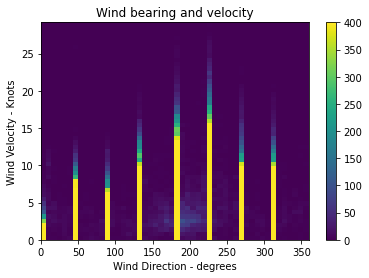

In [54]:
plt.hist2d(df['wind.bearing.mean'], df['wind.speed.mean'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind Direction - degrees')
plt.ylabel('Wind Velocity - Knots')
plt.title('Wind bearing and velocity');

Convert wind direction and speed to x and y vectors, so the model can more easily interpret them.

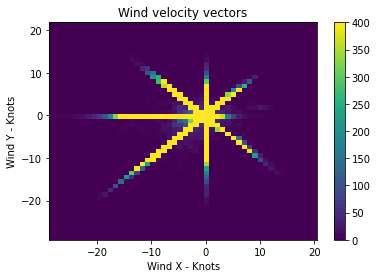

In [55]:
wv = df['wind.speed.mean']

# Convert to radians
wd_rad = df['wind.bearing.mean'] * np.pi / 180

# Calculate the wind x and y components
df['wind.x'] = wv * np.cos(wd_rad)
df['wind.y'] = wv * np.sin(wd_rad)

df_orig = df

plt.hist2d(df['wind.x'], df['wind.y'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind X - Knots')
plt.ylabel('Wind Y - Knots')
plt.title('Wind velocity vectors');


Better, but not ideal. Data augmentation with the [mixup method](https://arxiv.org/abs/1710.09412) is carried out below.

From the [mixup paper](https://arxiv.org/abs/1710.09412): "mixup trains a neural network on convex combinations of pairs of examples and their labels".

Further details on how I apply mixup to time series are included in the Window data section of my [keras_mlp_fcn_resnet_time_series.ipynb notebook](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb).

Here is an illustration of the improvement in wind velocity sparsity with mixup augmentation.

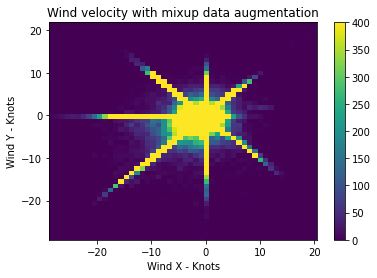

In [56]:
def mixup(data, alpha = 1.0, factor = 1):
    batch_size = len(data) - 1
    
    data['epoch'] = data.index.astype(np.int64) // 10**9
    
    # random sample lambda value from beta distribution
    l   = np.random.beta(alpha, alpha, batch_size * factor)
    X_l = l.reshape(batch_size * factor, 1)
    
    # Get a pair of inputs and outputs
    y1  = data['y'].shift(-1).dropna()
    y1_ = pd.concat([y1] * factor)
    
    y2  = data['y'][0:batch_size]
    y2_ = pd.concat([y2] * factor)

    X1  = data.drop('y', 1).shift(-1).dropna()
    X1_ = pd.concat([X1] * factor)
    
    X2  = data.drop('y', 1)
    X2  = X2[0:batch_size]
    X2_ = pd.concat([X2] * factor)

    # Perform mixup
    X = X1_ * X_l + X2_ * (1 - X_l)
    y = y1_ * l   + y2_ * (1 - l)    
    
    df = pd.DataFrame(y).join(X)    
    df = data.append(df).sort_values('epoch', ascending = True)
    df = df.drop('epoch', 1)
    
    df = df.drop_duplicates(keep = False)
    
    return df


df_mix = mixup(df.loc[:, ['y','wind.x','wind.y']], factor = 2)
plt.hist2d(df_mix['wind.x'], df_mix['wind.y'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind X - Knots')
plt.ylabel('Wind Y - Knots')
plt.title('Wind velocity with mixup data augmentation');

Mixup improves the categorical legacy of the wind velocity data. Unfortunately, if outliers are present their influence will likely be reinforced.

See my [keras_mlp_fcn_resnet_time_series.ipynb notebook](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb) for an illustration of the profoundly beneficial improvement mixup provides with this dataset.

---

### Time conversion

Convert `ds` timestamps to "time of day" and "time of year" variables using `sin` and `cos` functions.

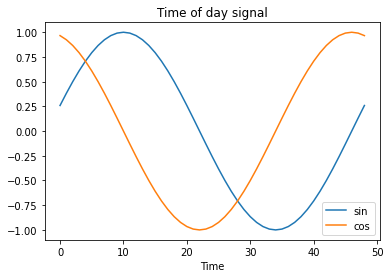

In [57]:
# Convert to secs
date_time   = pd.to_datetime(df['ds'], format = '%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

day  = 24 * 60 * 60
year = (365.2425) * day

df['day.sin']  = np.sin(timestamp_s * (2 * np.pi / day))
df['day.cos']  = np.cos(timestamp_s * (2 * np.pi / day))
df['year.sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year.cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['day.sin'])[49:98])
plt.plot(np.array(df['day.cos'])[49:98])
plt.xlabel('Time')
plt.legend(['sin', 'cos'], loc = 'lower right')
plt.title('Time of day signal');

The yearly time components may benefit from a single phase shift so they align with the seasonal temperature peak around the end of July and temperature trough around the end of January.  Similarly, the daily components may benefit from small daily phase shifts.

---

### Split data¶

I use data from 2018 for validation, 2019 for testing and the remaining data for training. These are entirely arbitrary choices. This results in an approximate 84%, 8%, 8% split for the training, validation, and test sets respectively.

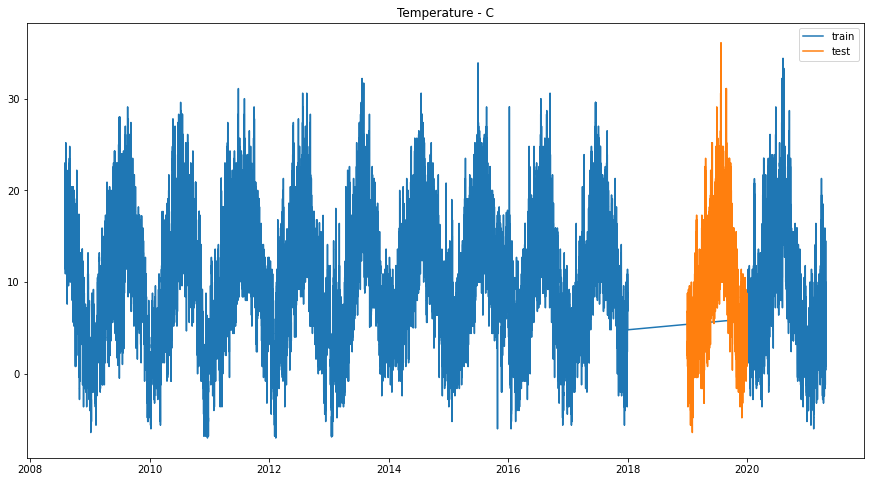

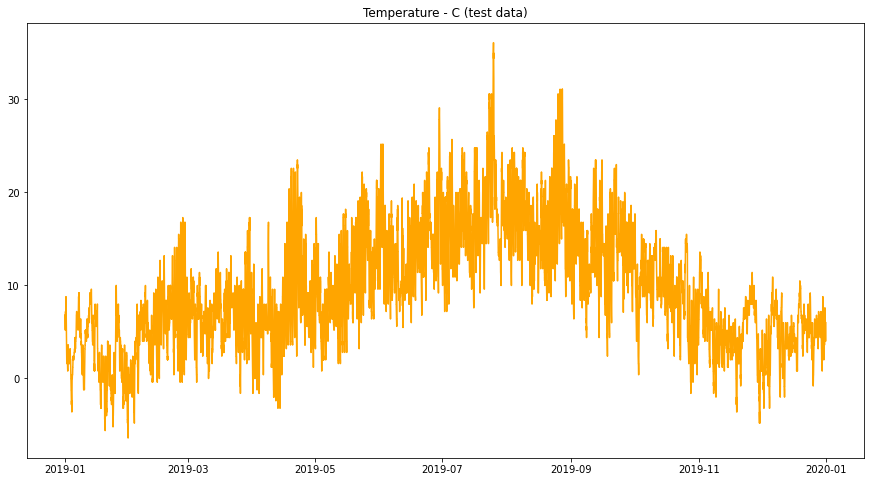

df.drop shape:  (223250, 10)
train shape:    (188210, 10)
valid shape:    (17520, 10)
test shape:     (17520, 10)


In [58]:
keep_cols = ['y', 'humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y',
             'day.sin', 'day.cos', 'year.sin', 'year.cos']

df['year'] = df['ds'].dt.year
train_df = df.loc[(df['year'] != 2018) & (df['year'] != 2019)]
valid_df = df.loc[df['year'] == 2018]
test_df  = df.loc[df['year'] == 2019]


plt.figure(figsize = (15, 8))
plt.plot(train_df.ds, train_df.y)
plt.plot(test_df.ds,   test_df.y)
plt.title('Temperature - C')
plt.legend(['train', 'test'])
plt.show()

plt.figure(figsize = (15, 8))
plt.plot(test_df.ds, test_df.y, color='orange')
plt.title('Temperature - C (test data)')
plt.show()


del_cols = ['ds', 'year', 'wind.speed.mean', 'wind.bearing.mean']
train_df = train_df.drop(del_cols, axis = 1)
valid_df = valid_df.drop(del_cols, axis = 1)
test_df  = test_df.drop(del_cols, axis = 1)
df = df.drop(del_cols, axis = 1)

print("df.drop shape: ", df.shape)
print("train shape:   ", train_df.shape)
print("valid shape:   ", valid_df.shape)
print("test shape:    ", test_df.shape)

The training data is used to calculate the seasonal average values.

---

### Normalise data

Features should be scaled before neural network training. Arguably, scaling should be done using moving averages to avoid accessing future values.
Instead, simple [standard score](https://en.wikipedia.org/wiki/Standard_score) normalisation will be used.

Plot [violin plot](https://en.wikipedia.org/wiki/Violin_plot) to see distribution of features.

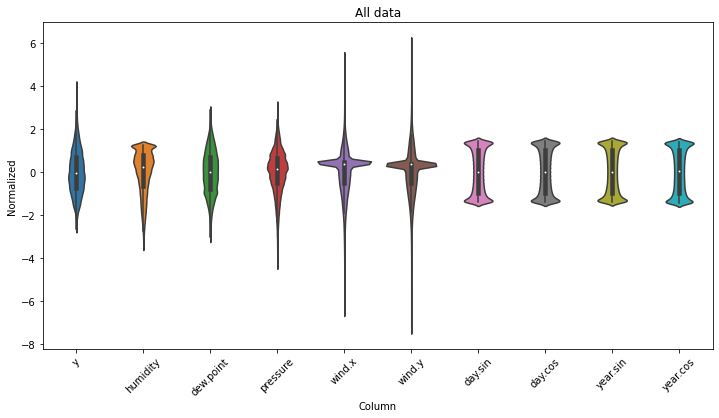

In [59]:
train_mean = train_df.mean()
train_std  = train_df.std()

train_df = (train_df - train_mean) / train_std
valid_df = (valid_df - train_mean) / train_std
test_df  = (test_df  - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data = df_std)
ax.set_xticklabels(df.keys(), rotation = 45)
ax.set_title('All data');

There may still be some outliers present but there are no glaring problems.

---

### Window data

Models are trained using sliding windows of samples from the data.

Window parameters to consider for the 
[tf.keras.preprocessing.timeseries_dataset_from_array](https://keras.io/api/preprocessing/timeseries/#timeseries-data-preprocessing) 
function:
 * sequence_length:
   * Length of the output sequences (in number of timesteps), or number of **lag** observations to use
 * sequence_stride:
   * Period between successive output sequences. For stride s, output samples start at index data[i], data[i + s], data[i + 2 * s] etc
s can include an **offset** and/or 1 or more **steps ahead** to forecast
 * batch_size:
   * Number of samples in each batch
 * shuffle:
   * Shuffle output samples, or use chronological order

Initial values used:
 * sequence_length (aka lags): 24 (corresponds to 12 hours)
 * steps ahead (what to forecast): 1 and separately 4 (corresponds to 30 mins and separately 30 mins, 60 mins, 90 mins, 120 mins)
 * offset (space between lags and steps ahead): 0
 * batch_size: 32
 * shuffle: True for training data

The `make_dataset` function below generates [tensorflow datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for:
 * Lags, steps-ahead, offset, batch size and shuffle
 * Optionally multiple y columns (Not extensively tested)
Stride is used to specify offset + steps-ahead. Offset will be 0 throughout this notebook.

**TODO** Insert figure illustrating lags, offsets and steps-ahead.

`shuffle = True` is used with train data. `shuffle = False` is used with validation and test data so the residuals can be checked for heteroscadicity.

Throughout this notebook I use a shorthand notation to describe lags and strides. For example:
 * 24l_1s is 24 lags 1 step ahead
 * 24l_4s is 24 lags 4 steps ahead

#### Mixup data augmentation

Data augmentation with 
[mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)
by Zhang et al is used to help counter the categorical legacy from the wind bearing variable. Simple 'input mixup' is used as opposed to the batch-based mixup Zhang et al focus on. Input mixup has the advantage that it can be used with non-neural network methods. Mixup is performed for train and validation data separately. With current settings these datasets are approximately 3 times larger but this can be varied. Three times more training data is manageable on Colab. Test and validation data is left unmodified.

I apply mixup between consecutive observations in the time series instead of the usual random observations. This is a fairly conservative starting point. I'd be surprised if applying mixup between consecutive days of measurements didn't give better results. Applying mixup between inputs with equal temperature values will not improve performance and will increase run time.

**TODO** Insert couple of examples of mixup - use `plot_examples()`

I don't show it in this notebook, but adding this data augmentation makes a big difference to loss values for all three model architectures. For example, here are comparable results for MLP, 24 largs, 1 step ahead, 20 epochs.

|Augmentation    |	Train rmse |	Train mae |	Valid rmse |	Valid mae |
|----------------|-------------|------------|------------|------------|
|No augmentation |	0.0058     |	0.053     |	0.0054     |	0.052     |
|Input mixup     |	0.0016     |	0.025     |	0.0015     |	0.025     |

See this [commit](https://github.com/makeyourownmaker/CambridgeTemperatureModel/blob/93c754d4b1b02e1bd8f827a6f6edc145824f6d23/notebooks/keras_mlp_fcn_resnet_time_series.ipynb) 
for results from other architectures without input mixup.

...

---

## LSTM Model Building

This notebook is being developed on [Google Colab](https://colab.research.google.com), primarily using [keras/tensorflow](https://www.tensorflow.org/guide/keras/sequential_model).

...

LSTM enhancements:
 * vanilla
 * mixup
 * timevec
 * Fourier terms?
 * test time augmentation
 * ...

...

Forecast horizons:
  * next 30 mins - 1 step ahead
  * next 2 hours - 4 steps ahead
  * next 24 hours - 48 steps ahead
  * horizon is abbreviated to `h` in the interrim results tables

Metrics considered:
 * rmse - root mean squared error
 * mae - median absolute error
 * mape - mean absolute percentage error

---

### ...

Firstly, vanilla LSTM:

simple average: 10.09
rmse: 6.42
mae:  4.89


...

---

...

h	rmse	mae
1 	 0.66 	 0.4
4 	 1.86 	 0.9
48 	 3.08 	 2.0




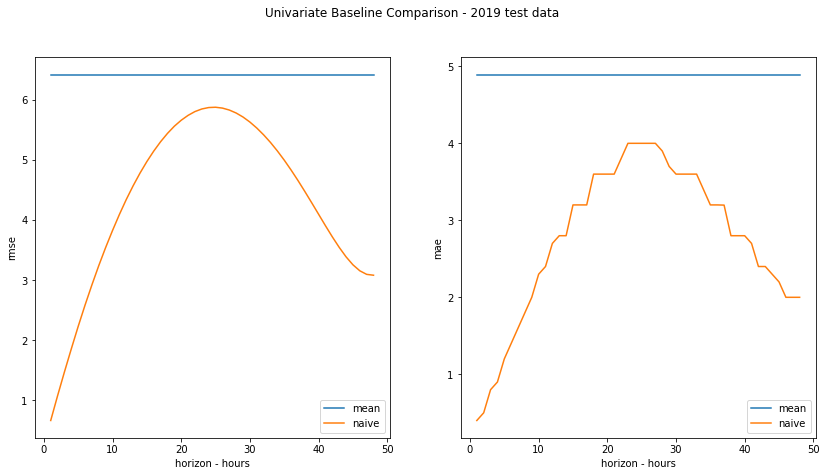

...

---


## Conclusion

Fortunately, ...

On an unrealted matter, ...

Future work:
 * ...

---

## Metadata

Python and Jupyter versions plus modules imported and their version strings. 
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer. 
There are simpler alternatives, such as watermark, but they all require installation.

In [ ]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

Python version:
/usr/bin/python3
3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]

IPython version:
5.5.0


In [ ]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

Imported modules:


name,version
statsmodels,0.10.2
pandas,1.1.5
numpy,1.19.5
matplotlib,3.2.2


In [ ]:
!date

Thu Apr 22 20:52:55 UTC 2021


---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

Notebook name is hardcoded below because the alternative is ghastly globs of unreliable javascript or external ipython libraries I'd prefer to avoid installing :-(

In [ ]:
from time import sleep

notebook = "cammet_baselines_2021.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}